# Dear HASHIM RESTART RUN TIME AFTER EXECUTING ABOVE CELL

In [55]:
%tensorflow_version 1.x
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import math
import random
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score
import glob
import collections
import operator
import copy
import seaborn as sns
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
RATING_FILE_NAME = dict({'movie': 'ratings.dat', 'book': 'BX-Book-Ratings.csv', 'news': 'ratings.txt'})
SEP = dict({'movie': '::', 'book': ';', 'news': '\t'})
THRESHOLD = dict({'movie': 4, 'book': 0, 'news': 0})
BASE_DIR = './drive/My Drive/Big Data Project/'

### Read Item Index to Entity Id File

In [0]:
def read_item_index_to_entity_id_file():
	file = os.path.join(BASE_DIR,'data/',DATASET,'item_index2entity_id_rehashed.txt')
	print('reading item index to entity id file: ' + file + ' ...')
	i = 0
	for line in open(file, encoding='utf-8').readlines():
		item_index = line.strip().split('\t')[0]
		satori_id = line.strip().split('\t')[1]
		item_index_old2new[item_index] = i
		entity_id2index[satori_id] = i
		i += 1

### Convert Rating

In [0]:

def convert_rating():
	file = os.path.join(BASE_DIR,'data/',DATASET, RATING_FILE_NAME[DATASET])
	print('reading rating file ...')
	item_set = set(item_index_old2new.values())
	user_pos_ratings = dict()
	user_neg_ratings = dict()

	for line in open(file, encoding='utf-8').readlines()[1:]:
		array = line.strip().split(SEP[DATASET])
		# remove prefix and suffix quotation marks for BX dataset
		if DATASET == 'book':
			array = list(map(lambda x: x[1:-1], array))
		item_index_old = array[1]
		if item_index_old not in item_index_old2new:  # the item is not in the final item set
			continue
		item_index = item_index_old2new[item_index_old]
		user_index_old = int(array[0])
		rating = float(array[2])
		if rating >= THRESHOLD[DATASET]:
			if user_index_old not in user_pos_ratings:
				user_pos_ratings[user_index_old] = set()
			user_pos_ratings[user_index_old].add(item_index)
		else:
			if user_index_old not in user_neg_ratings:
				user_neg_ratings[user_index_old] = set()
			user_neg_ratings[user_index_old].add(item_index)

	print('converting rating file ...')
	writer = open(os.path.join(BASE_DIR,'data',DATASET,'ratings_final.txt' ) , 'w', encoding='utf-8')
	user_cnt = 0
	user_index_old2new = dict()
	for user_index_old, pos_item_set in user_pos_ratings.items():
		if user_index_old not in user_index_old2new:
			user_index_old2new[user_index_old] = user_cnt
			user_cnt += 1
		user_index = user_index_old2new[user_index_old]
		for item in pos_item_set:
			writer.write('%d\t%d\t1\n' % (user_index, item))
		unwatched_set = item_set - pos_item_set
		if user_index_old in user_neg_ratings:
			unwatched_set -= user_neg_ratings[user_index_old]
		for item in np.random.choice(list(unwatched_set), size=len(pos_item_set)+100, replace=False):
			writer.write('%d\t%d\t0\n' % (user_index, item))
	writer.close()
	print('number of users: %d' % user_cnt)
	print('number of items: %d' % len(item_set))

### Convert Knowledge Graph

In [0]:

def convert_kg():
	print('converting kg file ...')
	entity_cnt = len(entity_id2index)
	relation_cnt = 0

	writer = open(os.path.join(BASE_DIR,'data',DATASET,'kg_final.txt' ), 'w', encoding='utf-8')

	files = []
	if DATASET == 'movie':
		files.append(open(os.path.join(BASE_DIR,'data',DATASET,'kg_part1_rehashed.txt' ), encoding='utf-8'))
		files.append(open(os.path.join(BASE_DIR,'data',DATASET,'kg_part2_rehashed.txt' ), encoding='utf-8'))
	else:
		files.append(open(os.path.join(BASE_DIR,'data',DATASET,'kg_rehashed.txt' ), encoding='utf-8'))
	cccn=0
	for file in files:
		for line in file:
			cccn+=1

			array = line.strip().split('\t')
			head_old = array[0]
			relation_old = array[1]
			tail_old = array[2]
			if head_old not in entity_id2index:
				entity_id2index[head_old] = entity_cnt
				entity_cnt += 1
			head = entity_id2index[head_old]
			if tail_old not in entity_id2index:
				entity_id2index[tail_old] = entity_cnt
				entity_cnt += 1
			tail = entity_id2index[tail_old]
			if relation_old not in relation_id2index:
				relation_id2index[relation_old] = relation_cnt
				relation_cnt += 1
			relation = relation_id2index[relation_old]
			writer.write('%d\t%d\t%d\n' %   (head, relation, tail)   )
	writer.close()
	print('number of entities (containing items): %d' % entity_cnt)
	print('number of relations: %d' % relation_cnt)

### Data Loader

In [0]:
def load_data():
    train_data, eval_data, test_data, user_history_dict = load_rating()
    n_entity, n_relation, kg = load_kg()
    ripple_set = get_ripple_set( kg, user_history_dict)
    return train_data, eval_data, test_data, n_entity, n_relation, ripple_set,user_history_dict

In [0]:
def load_rating():
    print('reading rating file ...')
    # reading rating file
    rating_file = os.path.join(BASE_DIR,'data',DATASET,'ratings_final' )
    
   # if os.path.exists(rating_file + '.npy'):
    #    rating_np = np.load(rating_file + '.npy')
   # else
   # if
    rating_np = np.loadtxt(rating_file + '.txt', dtype=np.int32)
    np.save(rating_file + '.npy', rating_np)

    # n_user = len(set(rating_np[:, 0]))
    # n_item = len(set(rating_np[:, 1]))
    return dataset_split(rating_np)

In [0]:
def load_kg():
    print('reading KG file ...')

    # reading kg file 
    kg_file = os.path.join(BASE_DIR,'data',DATASET,'kg_final' )
   # if os.path.exists(kg_file + '.npy'):
    #    kg_np = np.load(kg_file + '.npy')
    #else:
    kg_np = np.loadtxt(kg_file + '.txt', dtype=np.int32)
    np.save(kg_file + '.npy', kg_np)

    n_entity = len(set(kg_np[:, 0]) | set(kg_np[:, 2]))
    n_relation = len(set(kg_np[:, 1]))

    kg = construct_kg(kg_np)
    return n_entity, n_relation, kg

In [0]:
def construct_kg(kg_np):
    print('constructing knowledge graph ...')
    kg = collections.defaultdict(list)
    for head, relation, tail in kg_np:
        kg[head].append((tail, relation))
    return kg

In [0]:
def dataset_split(rating_np):
    print('splitting dataset ...')
    # train:eval:test = 6:2:2
    eval_ratio = 0.2
    test_ratio = 0.2
    n_ratings = rating_np.shape[0]

    eval_indices = np.random.choice(n_ratings, size=int(n_ratings * eval_ratio), replace=False)
    left = set(range(n_ratings)) - set(eval_indices)
    test_indices = np.random.choice(list(left), size=int(n_ratings * test_ratio), replace=False)
    train_indices = list(left - set(test_indices))
    # print(len(train_indices), len(eval_indices), len(test_indices))
    # traverse training data, only keeping the users with positive ratings
    user_history_dict = dict()
    for i in train_indices:
        user = rating_np[i][0]
        item = rating_np[i][1]
        rating = rating_np[i][2]
        if rating == 1:
            if user not in user_history_dict:
                user_history_dict[user] = []
            user_history_dict[user].append(item)

    train_indices = [i for i in train_indices if rating_np[i][0] in user_history_dict]
    eval_indices = [i for i in eval_indices if rating_np[i][0] in user_history_dict]
    test_indices = [i for i in test_indices if rating_np[i][0] in user_history_dict]
    # print(len(train_indices), len(eval_indices), len(test_indices))

    train_data = rating_np[train_indices]
    eval_data = rating_np[eval_indices]
    test_data = rating_np[test_indices]

    return train_data, eval_data, test_data, user_history_dict


In [0]:

def convert_sorted_counts2dictonary(keys,values):
    dictionary=dict()
    for index,key in enumerate(keys):
        dictionary[key]=values[index]
    dictionary=  (sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True )  )
    return dictionary

def get_ripple_set(kg, user_history_dict):
    print('constructing ripple set ...')

    # user -> [(hop_0_heads, hop_0_relations, hop_0_tails), (hop_1_heads, hop_1_relations, hop_1_tails), ...]
    ripple_set = collections.defaultdict(list)

    for user in user_history_dict:
        for h in range(n_hop):
            memories_h = []
            memories_r = []
            memories_t = []
            if h == 0:
                tails_of_last_hop = user_history_dict[user]
            else:
                tails_of_last_hop = ripple_set[user][-1][2]

            for entity in tails_of_last_hop:
                for tail_and_relation in kg[entity]:
                    memories_h.append(entity)
                    memories_r.append(tail_and_relation[1])
                    memories_t.append(tail_and_relation[0])
            
            # if the current ripple set of the given user is empty, we simply copy the ripple set of the last hop here
            # this won't happen for h = 0, because only the items that appear in the KG have been selected
            # this only happens on 154 users in Book-Crossing dataset (since both BX dataset and the KG are sparse)
            if len(memories_h) == 0:
                ripple_set[user].append(ripple_set[user][-1])
            else:
              
              if h==0:
                    selected_items_set=set()
                    similar_rated_items= []
                    for id_,similar_user in enumerate(collaborative_filtering[user][0]):
                        #print(user_history_dict[similar_user])
                        match_items=np.intersect1d(tails_of_last_hop,user_history_dict[similar_user]) 
                        for match_item  in match_items:
                          similar_rated_items.append(match_item)
                    similar_rated_items,selected_item_counts=np.unique(similar_rated_items,return_counts=True)
                    selected_sorted_items=convert_sorted_counts2dictonary(similar_rated_items,selected_item_counts)
                    for  (item,_) in (selected_sorted_items):
                         selected_items_set.add(item)
                    temp_memories_h=copy.deepcopy(np.array(memories_h))
                    temp_memories_r=copy.deepcopy(np.array(memories_r))
                    temp_memories_t=copy.deepcopy(np.array(memories_t))
                    memories_h,memories_r,memories_t=[],[],[]
                    for slected_item,_ in selected_sorted_items: 
                          indices=  (np.where(temp_memories_h==slected_item)[0])
                          for index_select in indices:
                                memories_h.append(temp_memories_h[index_select])
                                memories_r.append(temp_memories_r[index_select])
                                memories_t.append(temp_memories_t[index_select])
                    if len(memories_h)>=n_memory :           
                        memories_h=(memories_h)[:n_memory]
                        memories_r=(memories_r)[:n_memory]
                        memories_t=(memories_t)[:n_memory]
                        ripple_set[user].append((memories_h, memories_r, memories_t))
                    else:
                        print("My memory size is   ",len(memories_h))
                        print("Issue")
                        memory_requirement=False
                        remaining_items=n_memory - len(memories_h)
                        unselected_items= set(tails_of_last_hop)-selected_items_set
                        if unselected_items== set():
                          for requirement in range(remaining_items):
                              ind=np.random.choice(len(memories_h), size=remaining_items, replace=True)
                              for id_ in ind:
                                memories_h.append(memories_h[id_])
                                memories_r.append(memories_r[id_])
                                memories_t.append(memories_t[id_])
                          memories_h=memories_h[:n_memory]
                          memories_r=memories_r[:n_memory]
                          memories_t=memories_t[:n_memory]
                          ripple_set[user].append((memories_h, memories_r, memories_t))
                        else:
                          while memory_requirement==False:
                            print("----------------------",len(tails_of_last_hop),len(selected_items_set))
                            for item_id,unselected in enumerate(unselected_items):
                                    unselected_indices= (np.where(temp_memories_h==unselected)[0])
                                    for unselected_index in unselected_indices:
                                      memories_h.append(temp_memories_h[unselected_index])
                                      memories_r.append(temp_memories_r[unselected_index])
                                      memories_t.append(temp_memories_t[unselected_index])
                                      remaining_items-=1
                                    if len(memories_h)>=n_memory :  
                                          memory_requirement=True
                                        # print("break 1 :",type(memories_h),len(memories_h))
                                          break
                            if memory_requirement==True:
                                    #print("break 2 :",type(memories_h),len(memories_h))
                                    break
                          ripple_set[user].append((memories_h, memories_r, memories_t))     
              else:
                replace = len(memories_h) < n_memory
                indices = np.random.choice(len(memories_h), size=n_memory, replace=replace)
                memories_h = [memories_h[i] for i in indices]
                memories_r = [memories_r[i] for i in indices]
                memories_t = [memories_t[i] for i in indices]
                if len(memories_h)!=32 :
                    print("2 :",type(memories_h),len(memories_h))
                ripple_set[user].append((memories_h, memories_r, memories_t))
    return ripple_set

### Train

In [0]:
def train(args, data_info, show_loss):
    train_data = data_info[0]
    eval_data = data_info[1]
    test_data = data_info[2]
    n_entity = data_info[3]
    n_relation = data_info[4]
    ripple_set = data_info[5]
    model = RippleNet(args, n_entity, n_relation)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(args.n_epoch):
            # training
            np.random.shuffle(train_data)
            start = 0
            while start < train_data.shape[0]:
                _, loss = model.train(
                    sess, get_feed_dict(args, model, train_data, ripple_set, start, start + args.batch_size))
                start += args.batch_size
                if show_loss:
                    print('%.1f%% %.4f' % (start / train_data.shape[0] * 100, loss))
            # evaluation
            train_auc, train_acc = evaluation(sess, args, model, train_data, ripple_set, args.batch_size)
            eval_auc, eval_acc = evaluation(sess, args, model, eval_data, ripple_set, args.batch_size)
            test_auc, test_acc = evaluation(sess, args, model, test_data, ripple_set, args.batch_size)

            print('epoch %d    train auc: %.4f  acc: %.4f    eval auc: %.4f  acc: %.4f    test auc: %.4f  acc: %.4f'
                  % (step, train_auc, train_acc, eval_auc, eval_acc, test_auc, test_acc))

In [0]:
def get_feed_dict(args, model, data, ripple_set, start, end):
    feed_dict = dict()
    feed_dict[model.items] = data[start:end, 1]
    feed_dict[model.labels] = data[start:end, 2]
    for i in range(args.n_hop):
        feed_dict[model.memories_h[i]] = [ripple_set[user][i][0] for user in data[start:end, 0]]
        feed_dict[model.memories_r[i]] = [ripple_set[user][i][1] for user in data[start:end, 0]]
        feed_dict[model.memories_t[i]] = [ripple_set[user][i][2] for user in data[start:end, 0]]
    return feed_dict

In [0]:
def evaluation(sess, args, model, data, ripple_set, batch_size):
    start = 0
    auc_list = []
    acc_list = []
    while start < data.shape[0]:
        auc, acc = model.eval(sess, get_feed_dict(args, model, data, ripple_set, start, start + batch_size))
        auc_list.append(auc)
        acc_list.append(acc)
        start += batch_size
    return float(np.mean(auc_list)), float(np.mean(acc_list))

In [0]:
def SAVE(type):
    if type=="book":
        np.save('./drive/My Drive/Big Data Project/jaccard_matrix_book.npy',jaccard_matrix)
        np.save('./drive/My Drive/Big Data Project/collaborative_filtering_book.npy',collaborative_filtering)
        np.save('./drive/My Drive/Big Data Project/train_data_book.npy',train_data)
        np.save('./drive/My Drive/Big Data Project/eval_data_book.npy',eval_data)
        np.save('./drive/My Drive/Big Data Project/test_data_book.npy',test_data)
        np.save('./drive/My Drive/Big Data Project/user_history_dict_book.npy',user_history_dict)
        np.save('./drive/My Drive/Big Data Project/n_entity_book.npy',n_entity)
        np.save('./drive/My Drive/Big Data Project/n_relation_book.npy',n_relation)
        np.save('./drive/My Drive/Big Data Project/kg_book.npy',kg)
    elif type=="movie":
      np.save('./drive/My Drive/Big Data Project/jaccard_matrix.npy',jaccard_matrix)
      np.save('./drive/My Drive/Big Data Project/collaborative_filtering.npy',collaborative_filtering)
      np.save('./drive/My Drive/Big Data Project/train_data.npy',train_data)
      np.save('./drive/My Drive/Big Data Project/eval_data.npy',eval_data)
      np.save('./drive/My Drive/Big Data Project/test_data.npy',test_data)
      np.save('./drive/My Drive/Big Data Project/user_history_dict.npy',user_history_dict)
      np.save('./drive/My Drive/Big Data Project/n_entity.npy',n_entity)
      np.save('./drive/My Drive/Big Data Project/n_relation.npy',n_relation)
      np.save('./drive/My Drive/Big Data Project/kg.npy',kg)

In [0]:
def LOAD(type):
    if type=="book":
      jaccard_matrix=np.load('./drive/My Drive/Big Data Project/jaccard_matrix_book.npy')
      collaborative_filtering=np.load('./drive/My Drive/Big Data Project/collaborative_filtering_book.npy',allow_pickle=True)[()]
      train_data=np.load('./drive/My Drive/Big Data Project/train_data_book.npy')
      eval_data=np.load('./drive/My Drive/Big Data Project/eval_data_book.npy')
      test_data=np.load('./drive/My Drive/Big Data Project/test_data_book.npy')
      user_history_dict=np.load('./drive/My Drive/Big Data Project/user_history_dict_book.npy',allow_pickle=True)[()]
      n_entity=np.load('./drive/My Drive/Big Data Project/n_entity_book.npy')
      n_relation=np.load('./drive/My Drive/Big Data Project/n_relation_book.npy')
      kg=np.load('./drive/My Drive/Big Data Project/kg_book.npy',allow_pickle=True)[()]
    else:
      if type=="movie":
        jaccard_matrix=np.load('./drive/My Drive/Big Data Project/jaccard_matrix.npy')
        collaborative_filtering=np.load('./drive/My Drive/Big Data Project/collaborative_filtering.npy',allow_pickle=True)[()]
        train_data=np.load('./drive/My Drive/Big Data Project/train_data.npy',allow_pickle=True)
        eval_data=np.load('./drive/My Drive/Big Data Project/eval_data.npy',allow_pickle=True)
        test_data=np.load('./drive/My Drive/Big Data Project/test_data.npy',allow_pickle=True)
        user_history_dict=np.load('./drive/My Drive/Big Data Project/user_history_dict.npy',allow_pickle=True)[()]
        n_entity=np.load('./drive/My Drive/Big Data Project/n_entity.npy',allow_pickle=True)
        n_relation=np.load('./drive/My Drive/Big Data Project/n_relation.npy',allow_pickle=True)
        kg=np.load('./drive/My Drive/Big Data Project/kg.npy',allow_pickle=True)[()]
    return jaccard_matrix,collaborative_filtering,train_data,eval_data,test_data,user_history_dict,n_entity,n_relation,kg

### Model

In [0]:


class RippleNet(object):
    def __init__(self, args, n_entity, n_relation):
        self._parse_args(args, n_entity, n_relation)
        self._build_inputs()
        self._build_embeddings()
        self._build_model()
        self._build_loss()
        self._build_train()

    def _parse_args(self, args, n_entity, n_relation):
        self.n_entity = n_entity
        self.n_relation = n_relation
        self.dim = 16
        self.n_hop = args.n_hop
        self.kge_weight = args.kge_weight
        self.l2_weight = args.l2_weight
        self.lr = args.lr
        self.n_memory = args.n_memory
        self.item_update_mode = args.item_update_mode
        self.using_all_hops = args.using_all_hops

    def _build_inputs(self):
        self.items = tf.placeholder(dtype=tf.int32, shape=[None], name="items")
        self.labels = tf.placeholder(dtype=tf.float64, shape=[None], name="labels")
        self.memories_h = []
        self.memories_r = []
        self.memories_t = []

        for hop in range(self.n_hop):
            self.memories_h.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_h_" + str(hop)) )
            self.memories_r.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_r_" + str(hop)))
            self.memories_t.append(
                tf.placeholder(dtype=tf.int32, shape=[None, self.n_memory], name="memories_t_" + str(hop)))

    def _build_embeddings(self):
        print("----------------",self.n_entity, self.dim)
        self.entity_emb_matrix = tf.get_variable(name="entity_emb_matrix", dtype=tf.float64,
                                                 shape=[self.n_entity, self.dim],
                                                 initializer=tf.contrib.layers.xavier_initializer())
        self.relation_emb_matrix = tf.get_variable(name="relation_emb_matrix", dtype=tf.float64,
                                                   shape=[self.n_relation, self.dim, self.dim],
                                                   initializer=tf.contrib.layers.xavier_initializer())
    def _build_model(self):
        # transformation matrix for updating item embeddings at the end of each hop
        self.transform_matrix = tf.get_variable(name="transform_matrix", shape=[self.dim,self.dim],dtype=tf.float64,initializer=tf.contrib.layers.xavier_initializer())
        # [batch size, dim]
        self.item_embeddings = tf.nn.embedding_lookup(self.entity_emb_matrix, self.items)
        self.h_emb_list = []
        self.r_emb_list = []
        self.t_emb_list = []
        for i in range(self.n_hop):
            # [batch size, n_memory, dim]
            self.h_emb_list.append(tf.nn.embedding_lookup(self.entity_emb_matrix, self.memories_h[i]))

            # [batch size, n_memory, dim, dim]
            self.r_emb_list.append(tf.nn.embedding_lookup(self.relation_emb_matrix, self.memories_r[i]))

            # [batch size, n_memory, dim]
            self.t_emb_list.append(tf.nn.embedding_lookup(self.entity_emb_matrix, self.memories_t[i]))

        o_list = self._key_addressing()

        self.scores = tf.squeeze(self.predict(self.item_embeddings, o_list))
        self.scores_normalized = tf.sigmoid(self.scores)

    def _key_addressing(self):
        o_list = []
        for hop in range(self.n_hop):
            # [batch_size, n_memory, dim, 1]
            h_expanded = tf.expand_dims(self.h_emb_list[hop], axis=3)

            # [batch_size, n_memory, dim]
            Rh = tf.squeeze(tf.matmul(self.r_emb_list[hop], h_expanded), axis=3)
  
            # [batch_size, dim, 1]
            v = tf.expand_dims(self.item_embeddings, axis=2)
            # [batch_size, n_memory]
            probs = tf.squeeze(tf.matmul(Rh, v), axis=2)

            # [batch_size, n_memory]
            probs_normalized = tf.nn.softmax(probs)

            # [batch_size, n_memory, 1]
            probs_expanded = tf.expand_dims(probs_normalized, axis=2)

            # [batch_size, dim]
            o = tf.reduce_sum(self.t_emb_list[hop] * probs_expanded, axis=1)

            self.item_embeddings = self.update_item_embedding(self.item_embeddings, o)
            o_list.append(o)
        return o_list
    def update_item_embedding(self, item_embeddings, o):
        if self.item_update_mode == "replace":
            item_embeddings = o
        elif self.item_update_mode == "plus":
            item_embeddings = item_embeddings + o
        elif self.item_update_mode == "replace_transform":
            item_embeddings = tf.matmul(o, self.transform_matrix)
        elif self.item_update_mode == "plus_transform":
            item_embeddings = tf.matmul(item_embeddings + o, self.transform_matrix)
        else:
            raise Exception("Unknown item updating mode: " + self.item_update_mode)
        return item_embeddings
    def predict(self, item_embeddings, o_list):
        y = o_list[-1]
        if self.using_all_hops:
            for i in range(self.n_hop - 1):
                y += o_list[i]

        # [batch_size]
        scores = tf.reduce_sum(item_embeddings * y, axis=1)
        return scores

    def _build_loss(self):
        self.base_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.labels, logits=self.scores))

        self.kge_loss = 0
        for hop in range(self.n_hop):
            h_expanded = tf.expand_dims(self.h_emb_list[hop], axis=2)
            t_expanded = tf.expand_dims(self.t_emb_list[hop], axis=3)
            hRt = tf.squeeze(tf.matmul(tf.matmul(h_expanded, self.r_emb_list[hop]), t_expanded))
            self.kge_loss += tf.reduce_mean(tf.sigmoid(hRt))
        self.kge_loss = -self.kge_weight * self.kge_loss

        self.l2_loss = 0
        for hop in range(self.n_hop):
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.h_emb_list[hop] * self.h_emb_list[hop]))
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.t_emb_list[hop] * self.t_emb_list[hop]))
            self.l2_loss += tf.reduce_mean(tf.reduce_sum(self.r_emb_list[hop] * self.r_emb_list[hop]))
            if self.item_update_mode == "replace nonlinear" or self.item_update_mode == "plus nonlinear":
                self.l2_loss += tf.nn.l2_loss(self.transform_matrix)
        self.l2_loss = self.l2_weight * self.l2_loss

        self.loss = self.base_loss + self.kge_loss + self.l2_loss

    def _build_train(self):
        self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        '''
        optimizer = tf.train.AdamOptimizer(self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(self.loss))
        gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_norm=5)
                     for gradient in gradients]
        self.optimizer = optimizer.apply_gradients(zip(gradients, variables))
        '''
    def train(self, sess, feed_dict):
        return sess.run([self.optimizer, self.loss], feed_dict)

    def eval(self, sess, feed_dict):
        labels, scores = sess.run([self.labels, self.scores_normalized], feed_dict)
        auc = roc_auc_score(y_true=labels, y_score=scores)
        predictions = [1 if i >= 0.5 else 0 for i in scores]
        acc = np.mean(np.equal(predictions, labels))
        return auc, acc


## **Main Program**

### **Model Settings**

In [0]:
class Args():
    def __init__(self):
      self.dataset='movie'
      self.dim=16, 
      self.n_hop=2
      self.kge_weight=0.01
      self.l2_weight=1e-7
      self.lr=0.02
      self.batch_size=1024
      self.n_epoch=5
      self.n_memory=32
      self.item_update_mode='plus_transform'
      self.using_all_hops=True
args=Args()
args.n_hop
np.random.seed(555)
DATASET='movie'
dataset='movie'
dim=16, 
n_hop=2
kge_weight=0.01
l2_weight=1e-7
lr=0.02
batch_size=1024
n_epoch=5
n_memory=32
item_update_mode='plus_transform'
using_all_hops=True

In [0]:
entity_id2index = dict()
relation_id2index = dict()
item_index_old2new = dict()
read_item_index_to_entity_id_file()
convert_rating()
convert_kg()

# **Constant**

### **Collaborative Filtering**

In [0]:
print(user_history_dict)
user_keys=np.array(list(user_history_dict.keys()))
total_users=(sorted(user_keys)[-1])+1
jaccard_matrix=np.zeros((total_users,total_users),dtype=float)
for index_1,key_1 in enumerate(user_keys):
    for index_2,key_2 in enumerate(user_keys):
      if key_1!=key_2:
        similarity=len(np.intersect1d(user_history_dict[key_1],user_history_dict[key_2])) /len (np.union1d(user_history_dict[key_1],user_history_dict[key_2]))
        jaccard_matrix[key_1,key_2]=similarity
temp_jacccard=jaccard_matrix

{2: [12960, 260], 3: [1698, 8293, 3295], 4: [659], 5: [5], 6: [5], 7: [4263], 8: [5346, 777, 4173, 9887, 8209, 10936], 9: [288, 5, 399], 10: [1024], 11: [5347], 12: [633], 14: [2529, 5, 6224], 16: [10054], 17: [5088, 942, 601, 799], 18: [6048, 9], 19: [3063], 20: [8], 23: [5, 1759], 24: [2238], 25: [5, 7304, 10895, 1430, 290, 13866, 1323, 175, 10431, 2245, 709, 2255, 467, 487, 5227, 2418, 505], 26: [13441], 27: [11245], 28: [4481, 5, 9767, 2012, 7251, 1877, 3996, 4382], 30: [8], 32: [1492], 33: [5], 34: [643], 35: [6988], 36: [1460], 37: [3079, 5799], 38: [4978], 39: [1538, 7555, 1955, 3885, 13869, 9133, 9299, 7028, 2901, 8568, 6812], 40: [510], 43: [5853], 45: [3351], 46: [5814], 48: [8], 50: [1676, 103], 51: [9740, 702], 53: [1374], 54: [901], 55: [793], 57: [5481], 58: [12232], 59: [805], 60: [13872], 61: [5819], 62: [1093], 63: [4657, 4045], 65: [8], 66: [3694], 67: [5, 265, 3437, 7118, 2548, 347, 413], 68: [3523, 4805, 3016, 13873, 3090, 274], 70: [11660], 71: [5], 72: [266, 777, 

### **Top-K similar Users**

In [0]:
top_k_matches=100
collaborative_filtering = collections.defaultdict(list)
for key_user,similarity in enumerate(temp_jacccard):
        user_similiarity= (temp_jacccard[:,key_user])
        collaborative_filtering[key_user].append( user_similiarity.argsort()[-top_k_matches:][::-1])

### **Generating Knowledge Graph**

In [0]:
#train_data, eval_data, test_data, user_history_dict = load_rating()
#n_entity, n_relation, kg = load_kg()
ripple_set = get_ripple_set( kg, user_history_dict)
data_info=train_data, eval_data, test_data, n_entity, n_relation, ripple_set,user_history_dict


In [46]:
print("Train Data  ",(data_info[0]).shape)
print("Eval Data",(data_info[1]).shape)
print("Test Data",(data_info[2]).shape)
print("N Entity",data_info[3])
print("N Relation",data_info[4])
#print("Ripple Set",data_info[5])

Train Data   (860998, 3)
Eval Data (284316, 3)
Test Data (283902, 3)
N Entity 77903
N Relation 25


In [0]:
def plot_accuracy(train,val,test,path):
    plt.figure(figsize=(16,5))
    plt.plot(train)  ### **Model Analysis**
    plt.plot(val)
    plt.plot(test)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','val', 'test'], loc='upper left')
    plt.savefig(path)
    plt.show()


def plot_auc(train,val,test,path):
    plt.figure(figsize=(16,5))
    plt.plot(train)  ### **Model Analysis**
    plt.plot(val)
    plt.plot(test)
    plt.title('model auc')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','val', 'test'], loc='upper left')
    plt.savefig(path)
    plt.show()
def loss(train,path):
    plt.figure(figsize=(16,5))
    plt.plot(train)  ### **Model Analysis**
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.savefig(path)
    plt.show()

### **Book Movies Dataset**

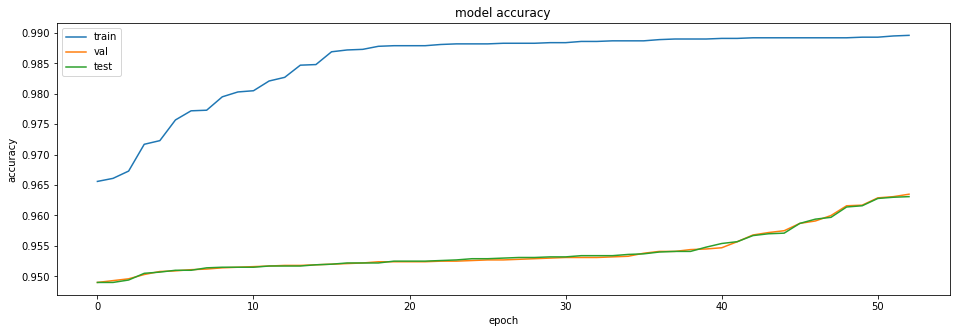

In [114]:
plots_books=np.load('./drive/My Drive/Big Data Project/Plots_books.npy')
plot_accuracy(plots_books[:,1],plots_books[:,3],plots_books[:,5],'./drive/My Drive/Big Data Project/PLOTS/1.jpg')


### **Area under curve on Book Dataset**

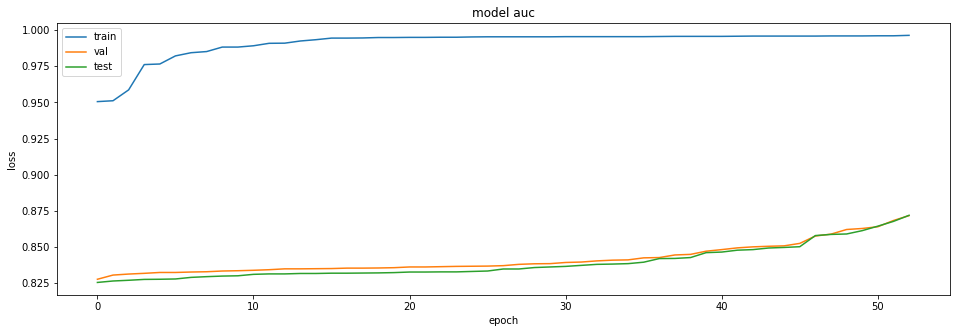

In [115]:
plot_auc(plots_books[:,0],plots_books[:,2],plots_books[:,4],'./drive/My Drive/Big Data Project/PLOTS/2.jpg')

### **Loss on Books Dataset**

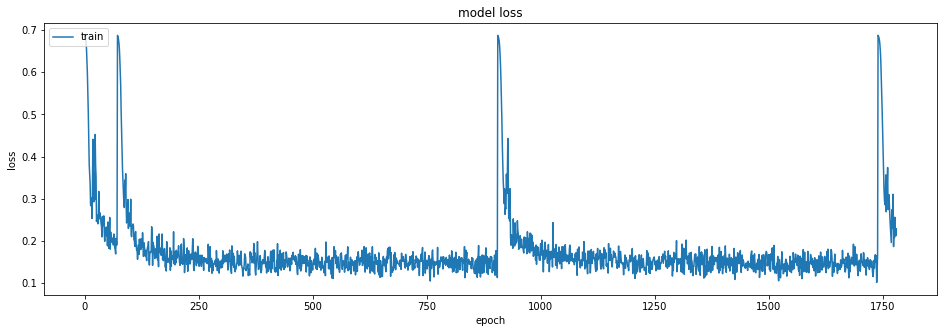

In [131]:
loss(np.load('./drive/My Drive/Big Data Project/myloss.npy'),'./drive/My Drive/Big Data Project/PLOTS/7.jpg')

### **Popularity of items in Book dataset**

In [0]:
jaccard_matrix,collaborative_filtering,train_data,eval_data,test_data,user_history_dict,n_entity,n_relation,kg=LOAD("book")
items_popularity=[]
for key in collaborative_filtering:
      for item in (collaborative_filtering[key][0]):
        items_popularity.append(item)
items_popularity, counts_items_popularity=np.unique(np.array(items_popularity),return_counts=True)
index_max_counts= np.argsort(-counts_items_popularity)[:20]
items, counts=items_popularity[index_max_counts], counts_items_popularity[index_max_counts]

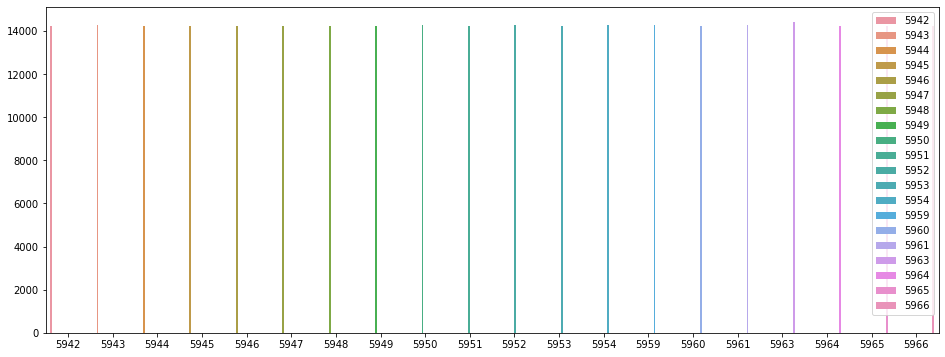

In [121]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x=items, y=counts,hue=items )
plt.savefig('./drive/My Drive/Big Data Project/PLOTS/3.jpg')

### **Accuracy on Movies Dataset**

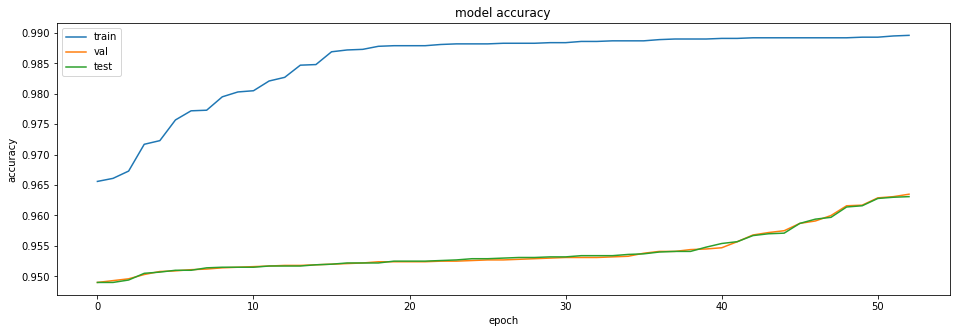

In [124]:
plots_movies=np.load('./drive/My Drive/Big Data Project/Plots_movies.npy')
plot_accuracy(plots_books[:,1],plots_books[:,3],plots_books[:,5],'./drive/My Drive/Big Data Project/PLOTS/4.jpg')

### **Area under curve on Movies Dataset**

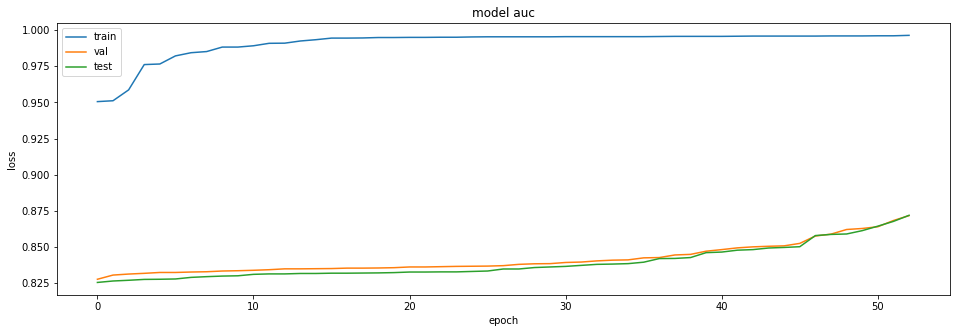

In [127]:
plot_auc(plots_books[:,0],plots_books[:,2],plots_books[:,4],'./drive/My Drive/Big Data Project/PLOTS/5.jpg')

### **Loss on Movies Dataset**

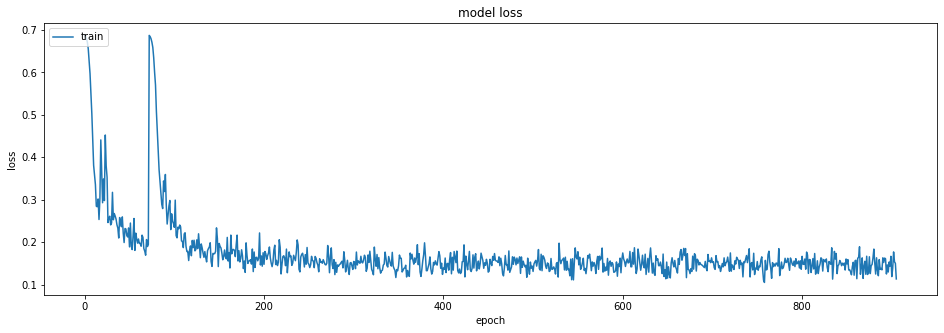

In [130]:
loss(np.load('./drive/My Drive/Big Data Project/myloss.npy'),'./drive/My Drive/Big Data Project/PLOTS/8.jpg')

### **Popularity of items in movie dataset**

In [0]:
jaccard_matrix,collaborative_filtering,train_data,eval_data,test_data,user_history_dict,n_entity,n_relation,kg=LOAD("movie")
items_popularity=[]
for key in collaborative_filtering:
      for item in (collaborative_filtering[key][0]):
        items_popularity.append(item)
items_popularity, counts_items_popularity=np.unique(np.array(items_popularity),return_counts=True)
index_max_counts= np.argsort(-counts_items_popularity)[:20]
items, counts=items_popularity[index_max_counts], counts_items_popularity[index_max_counts]

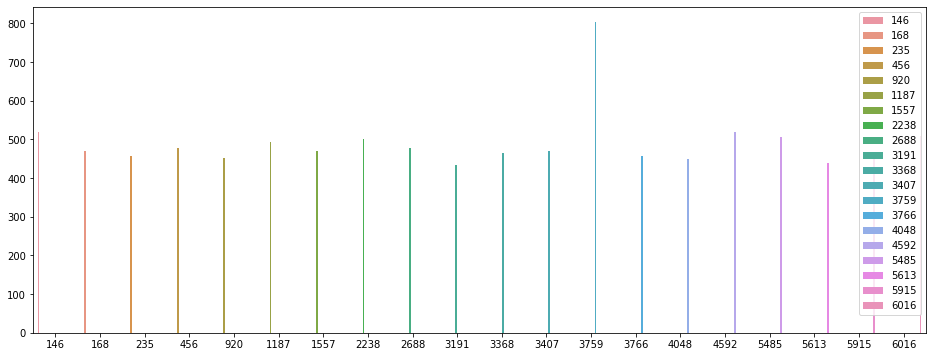

In [123]:
plt.figure(figsize=(16,6))
ax = sns.barplot(x=items, y=counts,hue=items )
plt.savefig('./drive/My Drive/Big Data Project/PLOTS/6.jpg')

###  **Training on  Books dataset**

In [0]:
show_loss = False
tf.reset_default_graph()
train(args,data_info, show_loss)

---------------- 77903 16
epoch 0    train auc: 0.9586  acc: 0.9673    eval auc: 0.8717  acc: 0.9631    test auc: 0.8719  acc: 0.9628
epoch 1    train auc: 0.9821  acc: 0.9757    eval auc: 0.8640  acc: 0.9600    test auc: 0.8644  acc: 0.9597
epoch 2    train auc: 0.9891  acc: 0.9805    eval auc: 0.8589  acc: 0.9591    test auc: 0.8587  acc: 0.9594
epoch 3    train auc: 0.9924  acc: 0.9847    eval auc: 0.8525  acc: 0.9557    test auc: 0.8502  acc: 0.9557
epoch 4    train auc: 0.9933  acc: 0.9848    eval auc: 0.8494  acc: 0.9538    test auc: 0.8465  acc: 0.9540
epoch 5    train auc: 0.9944  acc: 0.9869    eval auc: 0.8482  acc: 0.9544    test auc: 0.8482  acc: 0.9554
epoch 6    train auc: 0.9944  acc: 0.9872    eval auc: 0.8501  acc: 0.9545    test auc: 0.8461  acc: 0.9548
epoch 7    train auc: 0.9948  acc: 0.9878    eval auc: 0.8425  acc: 0.9522    test auc: 0.8382  acc: 0.9531
epoch 8    train auc: 0.9954  acc: 0.9882    eval auc: 0.8409  acc: 0.9527    test auc: 0.8395  acc: 0.9529
ep

###  **Training on  Movies dataset**

In [0]:
show_loss = False
tf.reset_default_graph()
train(args,data_info, show_loss)

---------------- 182011 16
epoch 0    train auc: 0.9150  acc: 0.8495    eval auc: 0.9075  acc: 0.8435    test auc: 0.9069  acc: 0.8431
epoch 1    train auc: 0.9266  acc: 0.8615    eval auc: 0.9161  acc: 0.8524    test auc: 0.9156  acc: 0.8521
epoch 2    train auc: 0.9358  acc: 0.8714    eval auc: 0.9214  acc: 0.8590    test auc: 0.9207  acc: 0.8576
epoch 3    train auc: 0.9417  acc: 0.8778    eval auc: 0.9243  acc: 0.8616    test auc: 0.9235  acc: 0.8615
epoch 4    train auc: 0.9455  acc: 0.8816    eval auc: 0.9258  acc: 0.8630    test auc: 0.9248  acc: 0.8623
epoch 5    train auc: 0.9490  acc: 0.8859    eval auc: 0.9268  acc: 0.8642    test auc: 0.9262  acc: 0.8637
epoch 6    train auc: 0.9502  acc: 0.8878    eval auc: 0.9265  acc: 0.8638    test auc: 0.9260  acc: 0.8633
epoch 7    train auc: 0.9535  acc: 0.8912    eval auc: 0.9260  acc: 0.8637    test auc: 0.9259  acc: 0.8632
epoch 8    train auc: 0.9545  acc: 0.8928    eval auc: 0.9263  acc: 0.8646    test auc: 0.9257  acc: 0.8637
e

KeyboardInterrupt: ignored